In [1]:
import pandas as pd
from math import log
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression, SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from math import ceil
from sklearn.utils.validation import check_is_fitted, column_or_1d

warnings.filterwarnings('ignore')

# OVERVIEW


The aim of the project is to develop a predictive model that predicts final prices of homes. This project is a submission for Kaggle House prices competition and Turing College to demostrate my knowledge of python and Machine Learning. 

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 



http://jse.amstat.org/v19n3/decock/DataDocumentation.txt has feature explanation

# GOALS and METRICS


The goal is to predict the sales price for each house. For each Id in the test set, the value of SalePrice variable must be predicted. The predicted values for test is evaluated using Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. 

In [2]:
def evaluation_metric(predicted_value, actual_value) -> float:
    '''
        Evaluation of predicted result against actual result using RMSE 
        between the logarithm of the predicted value and logarithm of observed value

        Parameters
            ----------
            Predicted value : array
                the predicted value from the model

            actual value: array
                the actual observed value

            Returns
            -------
            float
                root mean square error between the logarithm of the predicted value and logarithm of actual value

    '''
    rmse = mean_squared_error(np.log(actual_value),np.log(predicted_value), squared=False)
    return rmse

def verify_remodelling(remodelled_year:int, built_year:int):
    '''
        Compute if remodelling has been done on a house

        Parameters
            ----------
            remodelled_year : int
                the year remodel was done on the house

            built_year: int
                the year the house was built

            Returns
            -------
            bool
                returns True if remodel was done, False for None and -1 if discrepancy with the values
    '''
    if remodelled_year > built_year:
        return True
    elif remodelled_year == built_year:
        return False
    else:
        return -1


def selling_period(month_sold: int) -> str:
    '''
        Compute selling season
    '''
    if month_sold >= 3 and month_sold <= 5:
        return 'spring'
    elif month_sold >= 6 and month_sold <= 8:
        return 'summer'
    elif month_sold >= 9 and month_sold <= 11:
        return 'autumn'
    else:
        return 'winter'


RANDOM_STATE = 0


class TolerantLabelEncoder(LabelEncoder):
    def __init__(self, ignore_unknown=False,
                       unknown_original_value='unknown', 
                       unknown_encoded_value=-1):
        self.ignore_unknown = ignore_unknown
        self.unknown_original_value = unknown_original_value
        self.unknown_encoded_value = unknown_encoded_value

    def transform(self, y):
        check_is_fitted(self, 'classes_')
        y = column_or_1d(y, warn=True)

        indices = np.isin(y, self.classes_)
        if not self.ignore_unknown and not np.all(indices):
            raise ValueError("y contains new labels: %s" 
                                         % str(np.setdiff1d(y, self.classes_)))

        y_transformed = np.searchsorted(self.classes_, y)
        y_transformed[~indices]=self.unknown_encoded_value
        return y_transformed

    def inverse_transform(self, y):
        check_is_fitted(self, 'classes_')

        labels = np.arange(len(self.classes_))
        indices = np.isin(y, labels)
        if not self.ignore_unknown and not np.all(indices):
            raise ValueError("y contains new labels: %s" 
                                         % str(np.setdiff1d(y, self.classes_)))

        y_transformed = np.asarray(self.classes_[y], dtype=object)
        y_transformed[~indices]=self.unknown_original_value
        return y_transformed

# EXPLORATION

In [3]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [4]:
''' 
    Ordinal Ranking Meaning

    Ex	Excellent
    Gd	Good
    TA	Typical/Average
    Fa	Fair
    Po	Poor

'''
ms_sub_class = {20:'1-STORY 1946 & NEWER ALL STYLES', 30:'1-STORY 1945 & OLDER', 40:'1-STORY W/FINISHED ATTIC ALL AGES',50:'1-1/2 STORY FINISHED ALL AGES',
                60: '2-STORY 1946 & NEWER', 70: '2-STORY 1945 & OLDER', 75:'2-1/2 STORY ALL AGES', 80:'SPLIT OR MULTI-LEVEL', 85:'SPLIT FOYER',
                90: 'DUPLEX - ALL STYLES AND AGES', 120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER', 150:'1-1/2 STORY PUD - ALL AGES',
                160:'2-STORY PUD - 1946 & NEWER', 180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', 190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}

ordinal_ranking = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, 'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'Reg':3, 'IR1':2, 'IR2':1,'IR3':0,'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 
            'ELO':1, 'Gtl':3, 'Mod':2, 'Sev':1, 'Av':3, 'Mn':2, 'No':1, 'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':2, 'LwQ':1, 'Unf':-1, 'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5,
            'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1, 'Fin':2, 'RFn':1}

continious_features =['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea',
                      'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal','LotFrontage', 'age_of_building','total_square_footage',
                      'total_area_of_house']
norminal_features = ['MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LotConfig','Neighborhood','Condition1','Condition2', 'BldgType','HouseStyle','RoofStyle', 'RoofMatl',
                    'Exterior1st', 'Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','GarageType','GarageYrBlt','PavedDrive', 'SaleType',
                    'SaleCondition','Electrical', 'Alley', 'MiscFeature', 'remodelling_done', 'selling_season']
discrete_features = ['YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',
                     'MoSold', 'YrSold']
ordinal_cat_features = ['LotShape', 'Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond', 'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC'
                        ,'KitchenQual', 'Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC','Fence']
ordinal_num_features = ['OverallQual','OverallCond' ]

## Engineering New Columns

In [5]:
train_set['total_square_footage'] = train_set['TotalBsmtSF'] + train_set['GrLivArea']
test_set['total_square_footage'] = test_set['TotalBsmtSF'] + test_set['GrLivArea']

train_set['remodelling_done'] = train_set.apply(lambda x: verify_remodelling(x['YearRemodAdd'], x['YearBuilt']), axis=1)
test_set['remodelling_done'] = test_set.apply(lambda x: verify_remodelling(x['YearRemodAdd'], x['YearBuilt']), axis=1)

train_set['selling_season'] = train_set.apply(lambda x: selling_period(x['MoSold']), axis=1)
test_set['selling_season'] = test_set.apply(lambda x: selling_period(x['MoSold']), axis=1)

train_set['total_area_of_house'] = train_set['TotalBsmtSF'] + train_set['1stFlrSF'] + train_set['2ndFlrSF']
test_set['total_area_of_house'] = test_set['TotalBsmtSF'] + test_set['1stFlrSF'] + test_set['2ndFlrSF']

train_set['age_of_building'] = train_set['YearBuilt'].apply(lambda x: pd.datetime.now().year - x)
test_set['age_of_building'] = test_set['YearBuilt'].apply(lambda x: pd.datetime.now().year - x)

It can be seen below that both test and train dataset have missing values. 

In [6]:
train_set.isnull().sum()

Id                        0
MSSubClass                0
MSZoning                  0
LotFrontage             259
LotArea                   0
                       ... 
total_square_footage      0
remodelling_done          0
selling_season            0
total_area_of_house       0
age_of_building           0
Length: 86, dtype: int64

In [7]:
test_set.isnull().sum()

Id                        0
MSSubClass                0
MSZoning                  4
LotFrontage             227
LotArea                   0
                       ... 
total_square_footage      1
remodelling_done          0
selling_season            0
total_area_of_house       1
age_of_building           0
Length: 85, dtype: int64

## Ordinal Features
For Ordinal categorical features, missing values will be filled with NA (0)

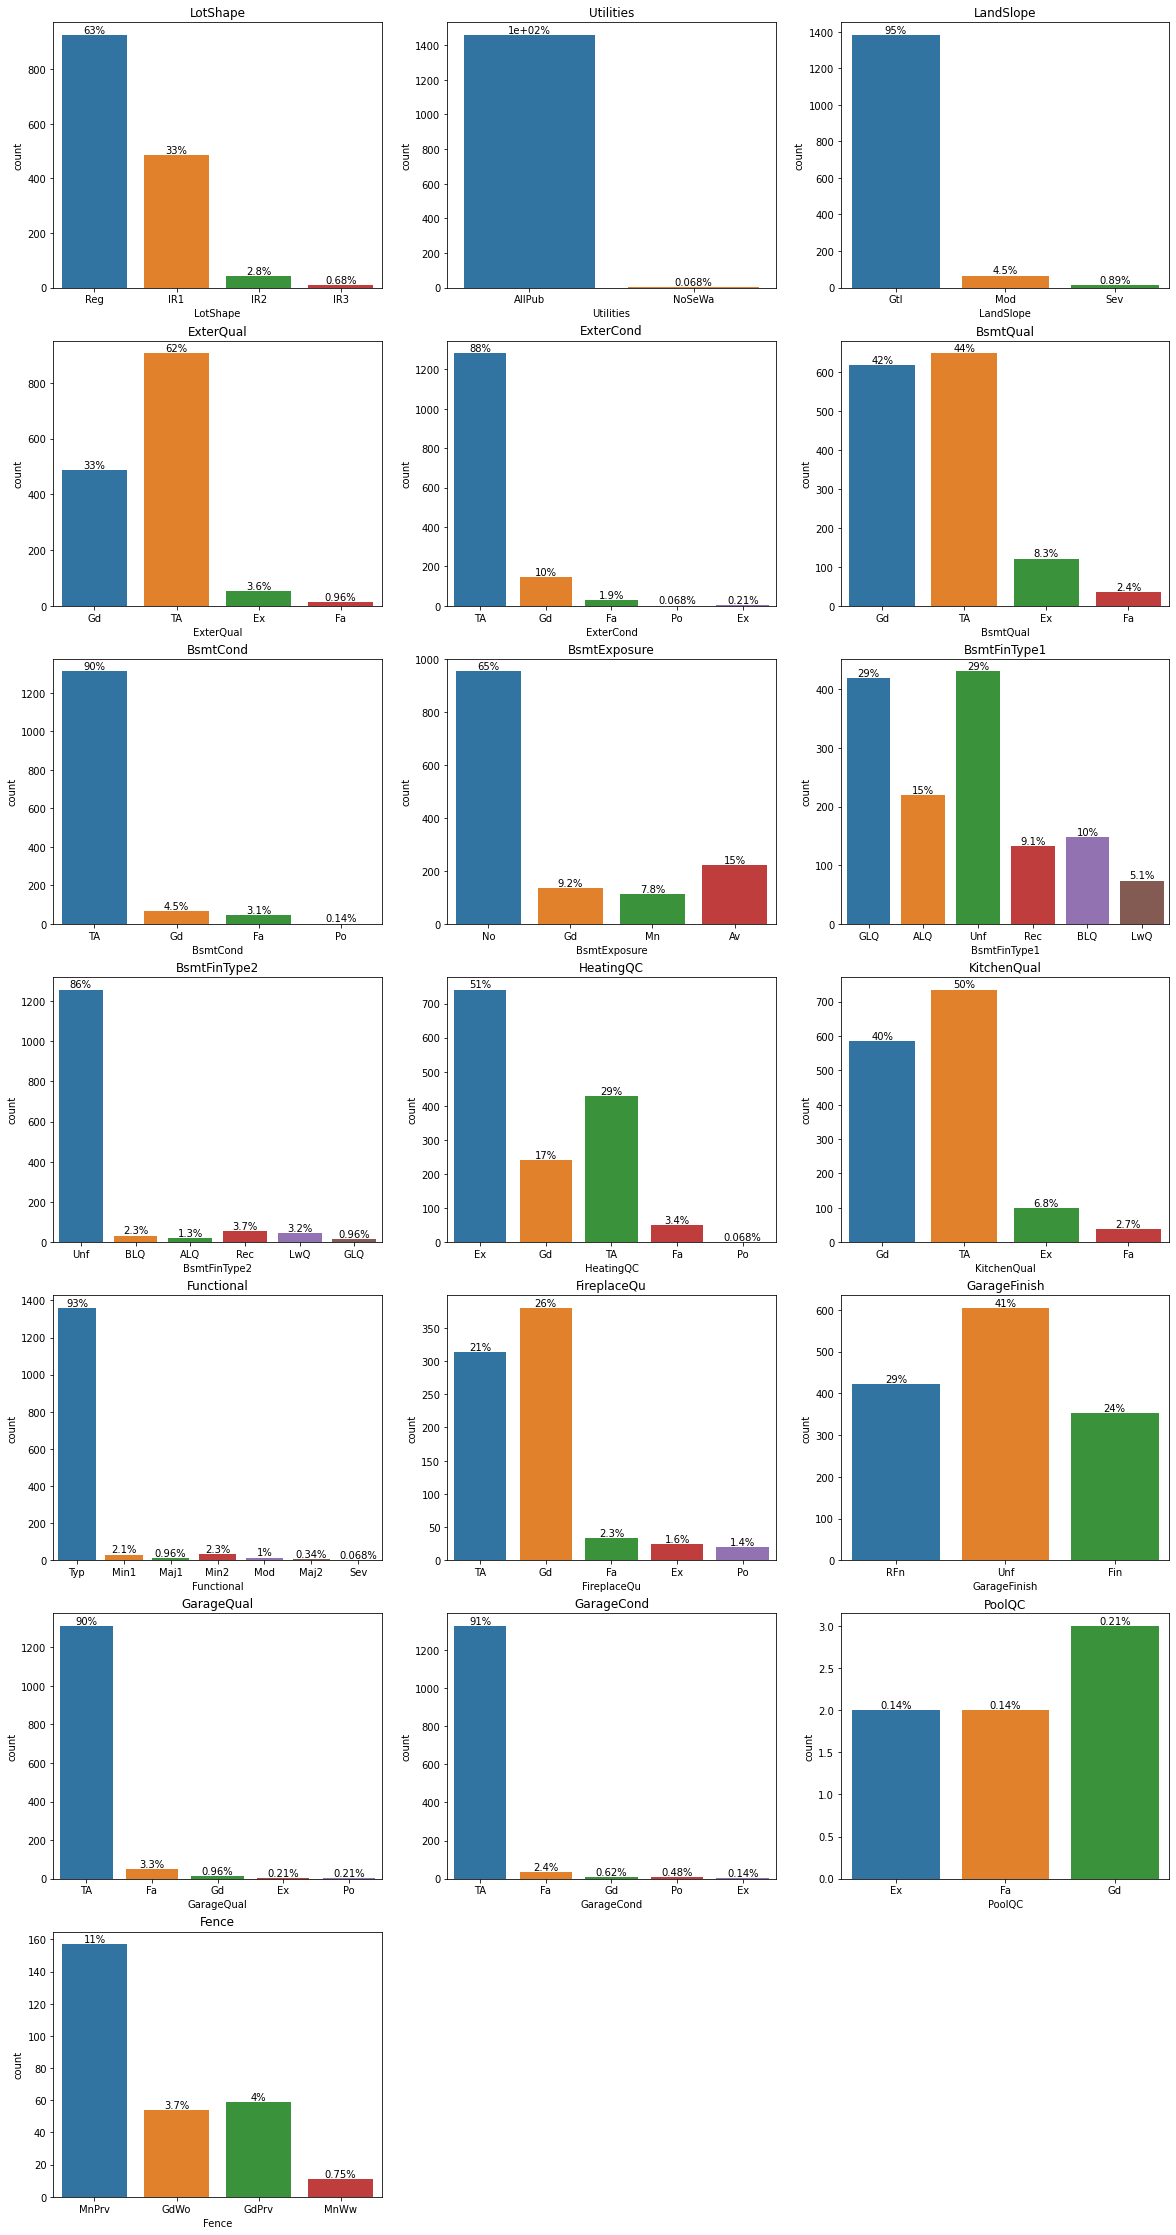

In [8]:
n_cols = 3
n_rows = ceil(len(ordinal_cat_features)/n_cols)
counter = 1

fig = plt.figure(figsize=(20,40))
for col in ordinal_cat_features:
    plt.subplot(n_rows, n_cols, counter)
    plt.title('{}'.format(col))
    plt.xlabel(col)
    g = sns.countplot(train_set[col])
    for p in g.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        g.annotate('{:.2g}%'.format(100.*y/len(train_set[col])), (x.mean(), y), ha='center', va='bottom')
    counter += 1

plt.show();

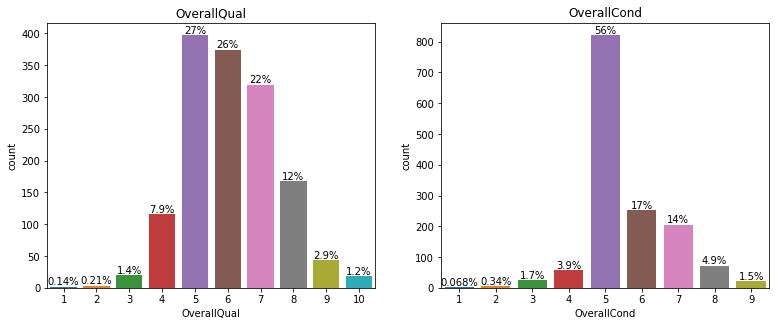

In [9]:
fig = plt.figure(figsize=(20,40))
for col in ordinal_num_features:
    plt.subplot(n_rows, n_cols, counter)
    plt.title('{}'.format(col))
    plt.xlabel(col)
    g = sns.countplot(train_set[col])
    for p in g.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        g.annotate('{:.2g}%'.format(100.*y/len(train_set[col])), (x.mean(), y), ha='center', va='bottom')
    counter += 1

plt.show();

In [10]:
for col in ordinal_cat_features:
    train_set[col] = train_set[col].map(ordinal_ranking)
    test_set[col] = test_set[col].map(ordinal_ranking)
    train_set[col] = train_set[col].fillna(0)
    test_set[col] = test_set[col].fillna(0)

## Continious Features
Since there are few missing values in continious features, the missing values are replaced with 0

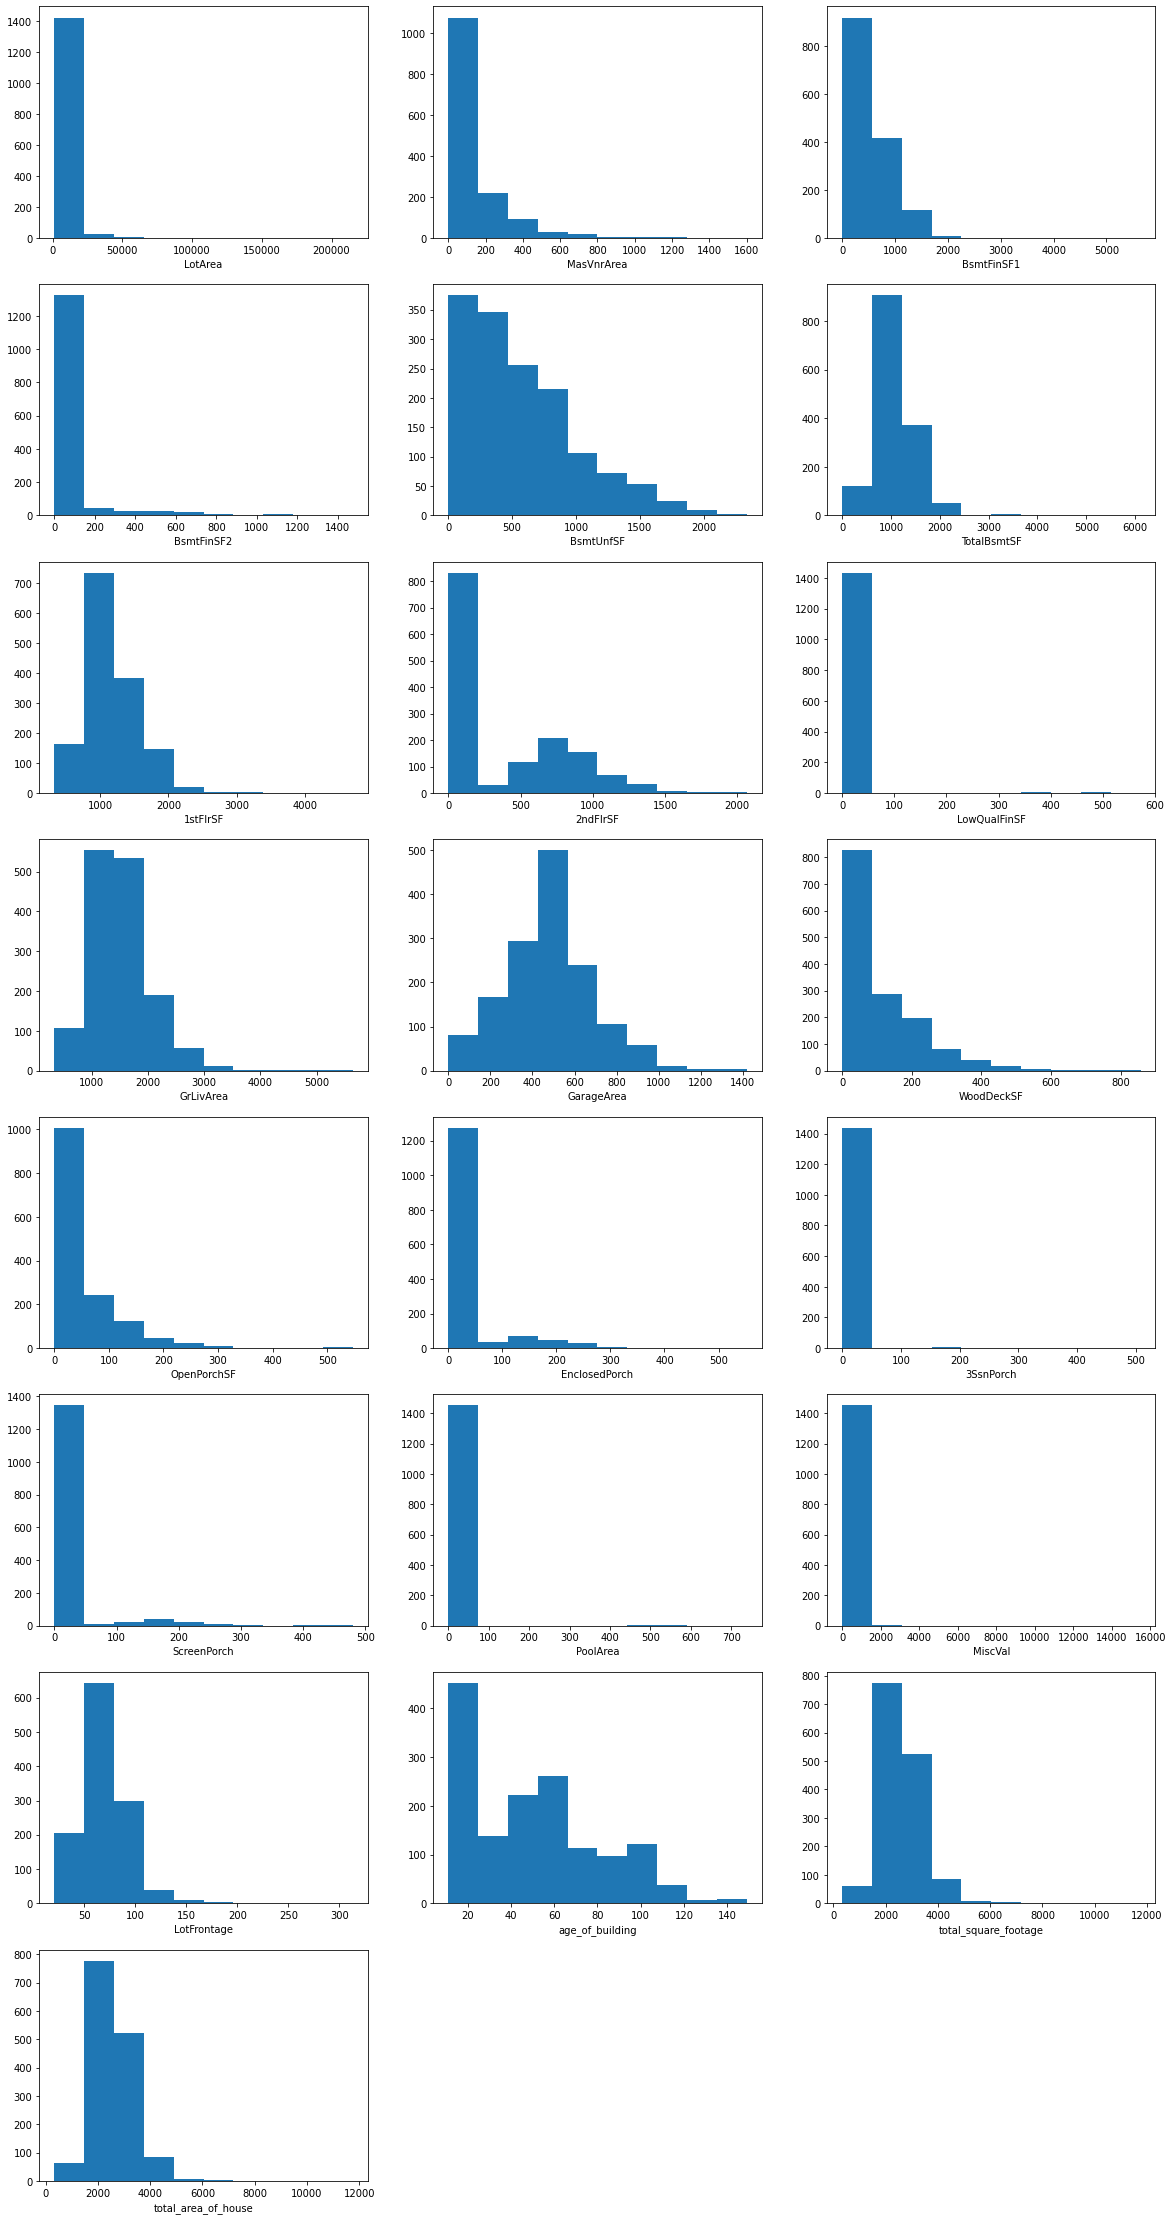

In [11]:
n_cols = 3
n_rows = ceil(len(continious_features)/n_cols)
counter = 1

fig = plt.figure(figsize=(20,40))
for col in continious_features:
    plt.subplot(n_rows, n_cols, counter)
    plt.xlabel(col)
    g = plt.hist(train_set[col])
    
    counter += 1

plt.show();

In [12]:
for col in continious_features:
    train_set[col] = train_set[col].fillna(0)
    test_set[col] = test_set[col].fillna(0)


## Nominal Features

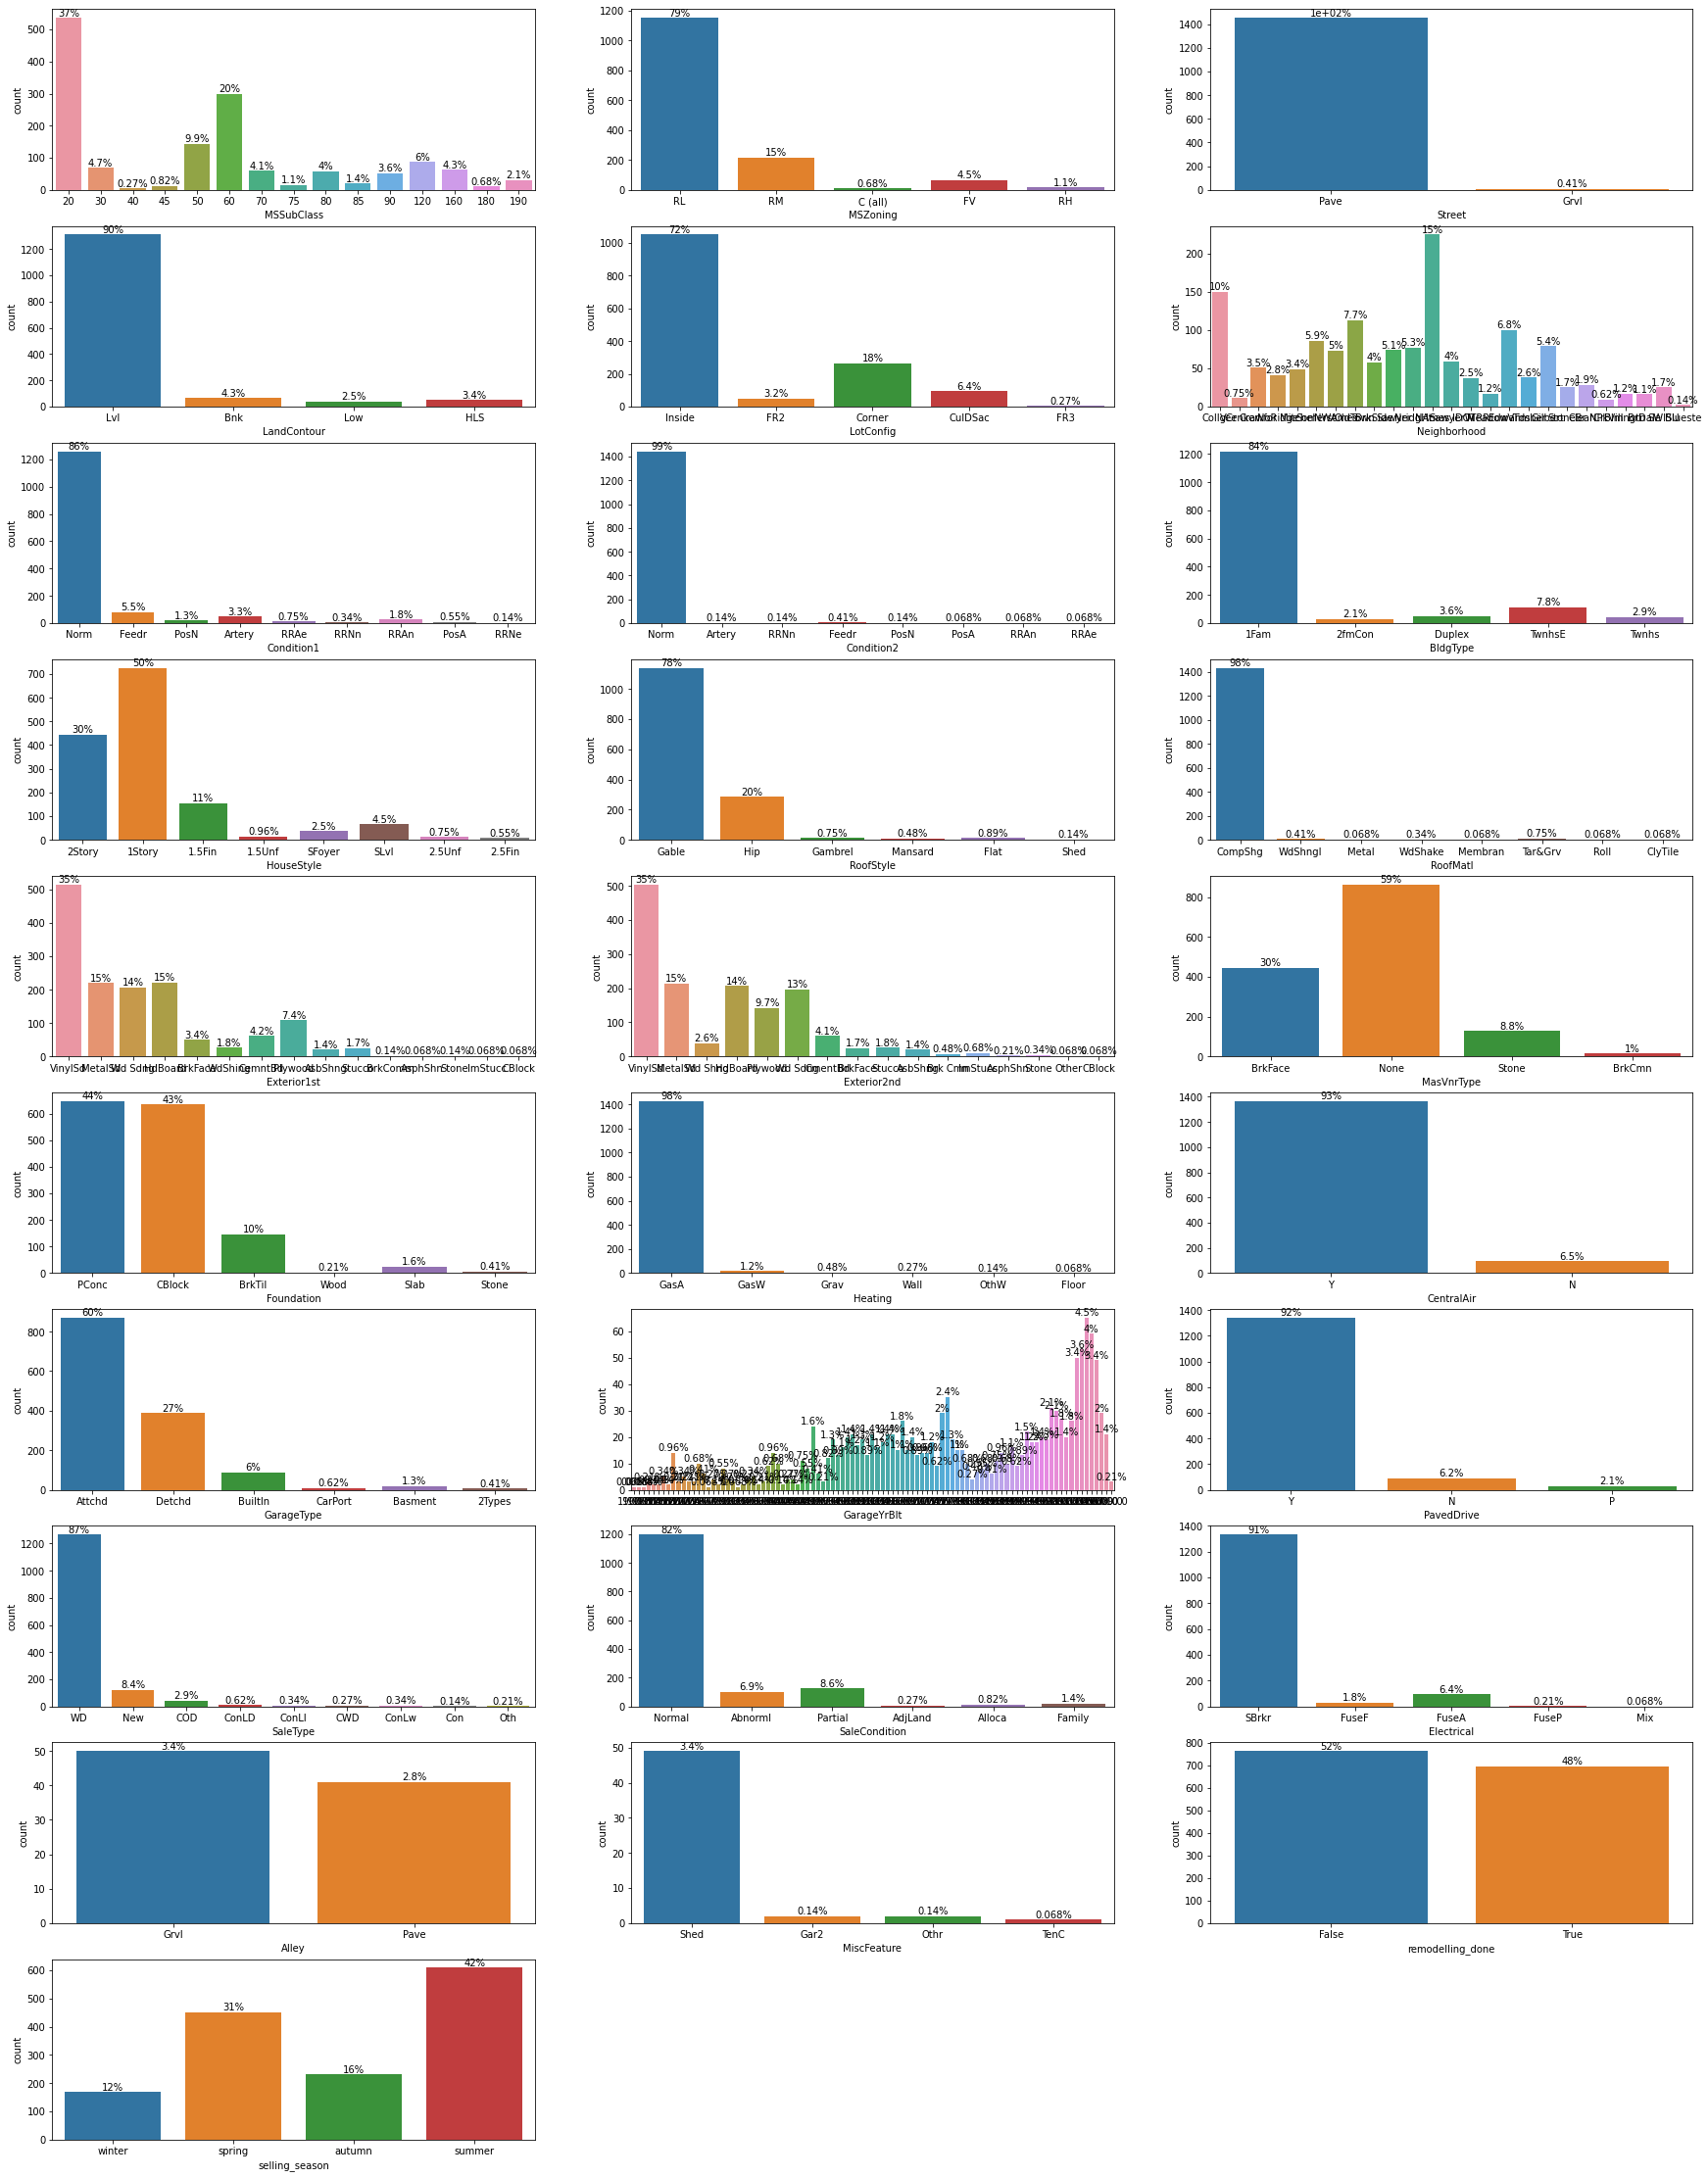

In [13]:
n_cols = 3
n_rows = ceil(len(norminal_features)/n_cols)
counter = 1

fig = plt.figure(figsize=(30,40))
for col in norminal_features:
    plt.subplot(n_rows, n_cols, counter)
    plt.xlabel(col)
    g = sns.countplot(train_set[col])
    for p in g.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        g.annotate('{:.2g}%'.format(100.*y/len(train_set[col])), (x.mean(), y), ha='center', va='bottom')
    counter += 1

plt.show();

In [14]:
train_set[norminal_features].isnull().sum()

MSSubClass             0
MSZoning               0
Street                 0
LandContour            0
LotConfig              0
Neighborhood           0
Condition1             0
Condition2             0
BldgType               0
HouseStyle             0
RoofStyle              0
RoofMatl               0
Exterior1st            0
Exterior2nd            0
MasVnrType             8
Foundation             0
Heating                0
CentralAir             0
GarageType            81
GarageYrBlt           81
PavedDrive             0
SaleType               0
SaleCondition          0
Electrical             1
Alley               1369
MiscFeature         1406
remodelling_done       0
selling_season         0
dtype: int64

### MS SubClass: Identifies the type of dwelling involved in the sale
The highest number of house type in the dataset is 1-STORY 1946 & NEWER ALL STYLES

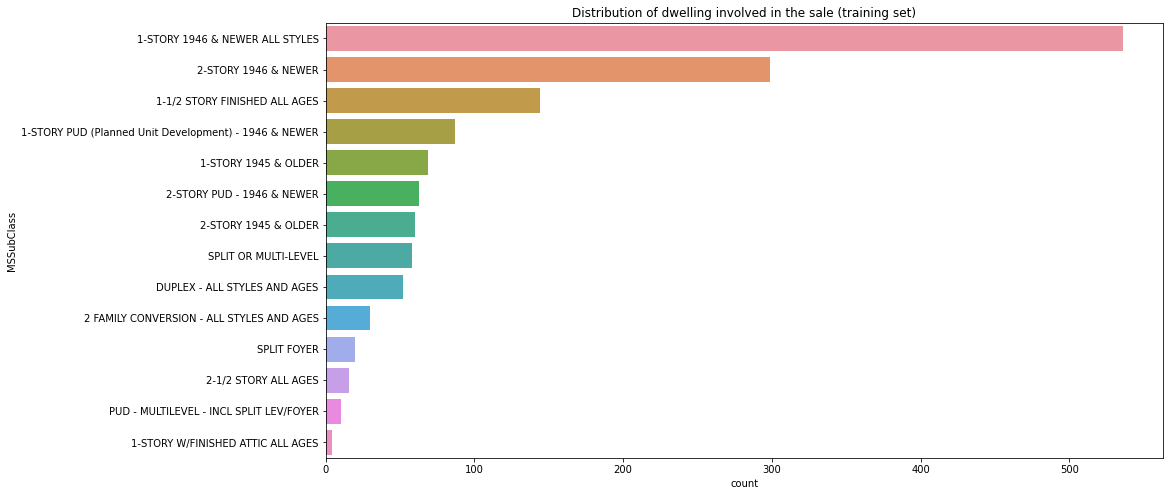

In [15]:
plt.figure(figsize=(15,8))

ax = sns.countplot(y=train_set.MSSubClass.map(ms_sub_class), order=train_set.MSSubClass.map(ms_sub_class).value_counts().index)
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.title('Distribution of dwelling involved in the sale (training set)')
plt.show();


### MS Zoning: Identifies the general zoning classification of the sale.
The testset has 4 null values and are replaced with the modevalue

In [16]:
test_set['MSZoning'].isnull().sum()

4

In [17]:

test_set['MSZoning'].mode()

0    RL
dtype: object

In [18]:
test_set['MSZoning'] = test_set['MSZoning'].fillna('RL')

## Discrete Features
Most of the houses

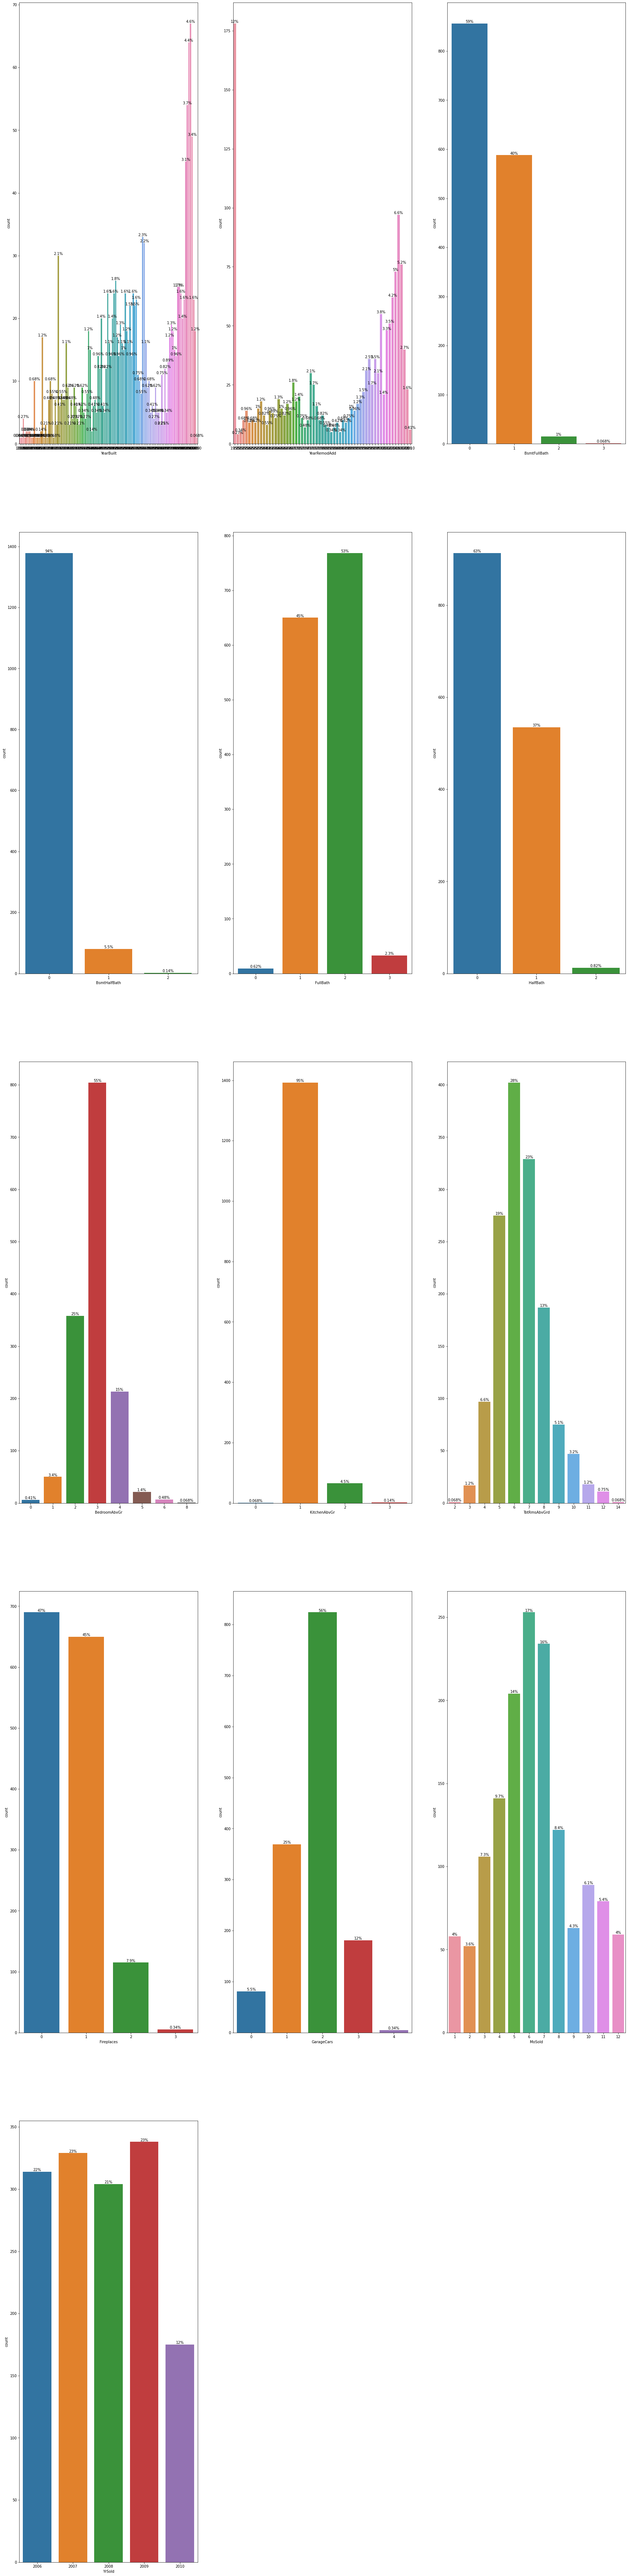

In [19]:
n_cols = 3
n_rows = ceil(len(discrete_features)/n_cols)
counter = 1

fig = plt.figure(figsize=(30,130))
for col in discrete_features:
    plt.subplot(n_rows, n_cols, counter)
    plt.xlabel(col)
    g = sns.countplot(train_set[col])
    for p in g.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        g.annotate('{:.2g}%'.format(100.*y/len(train_set[col])), (x.mean(), y), ha='center', va='bottom')
    counter += 1

plt.show();

# FEATURE ANALYSIS

## Outliers
It can be seen that there is a positive relationship between Sale Price and  Above grade (ground) living area square feet. In the scatter plot below, four points are above 4000 Above grade (ground) living area square feet and are excluded from the train_set

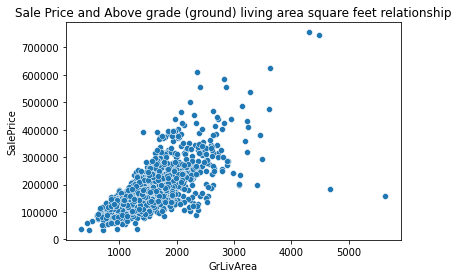

In [20]:
sns.scatterplot(data=train_set, x = 'GrLivArea', y='SalePrice');
plt.title('Sale Price and Above grade (ground) living area square feet relationship');

In [21]:
train_set = train_set[train_set['GrLivArea'] < 4000]

## Correlation

In [22]:
corr_matrix = train_set.corr()

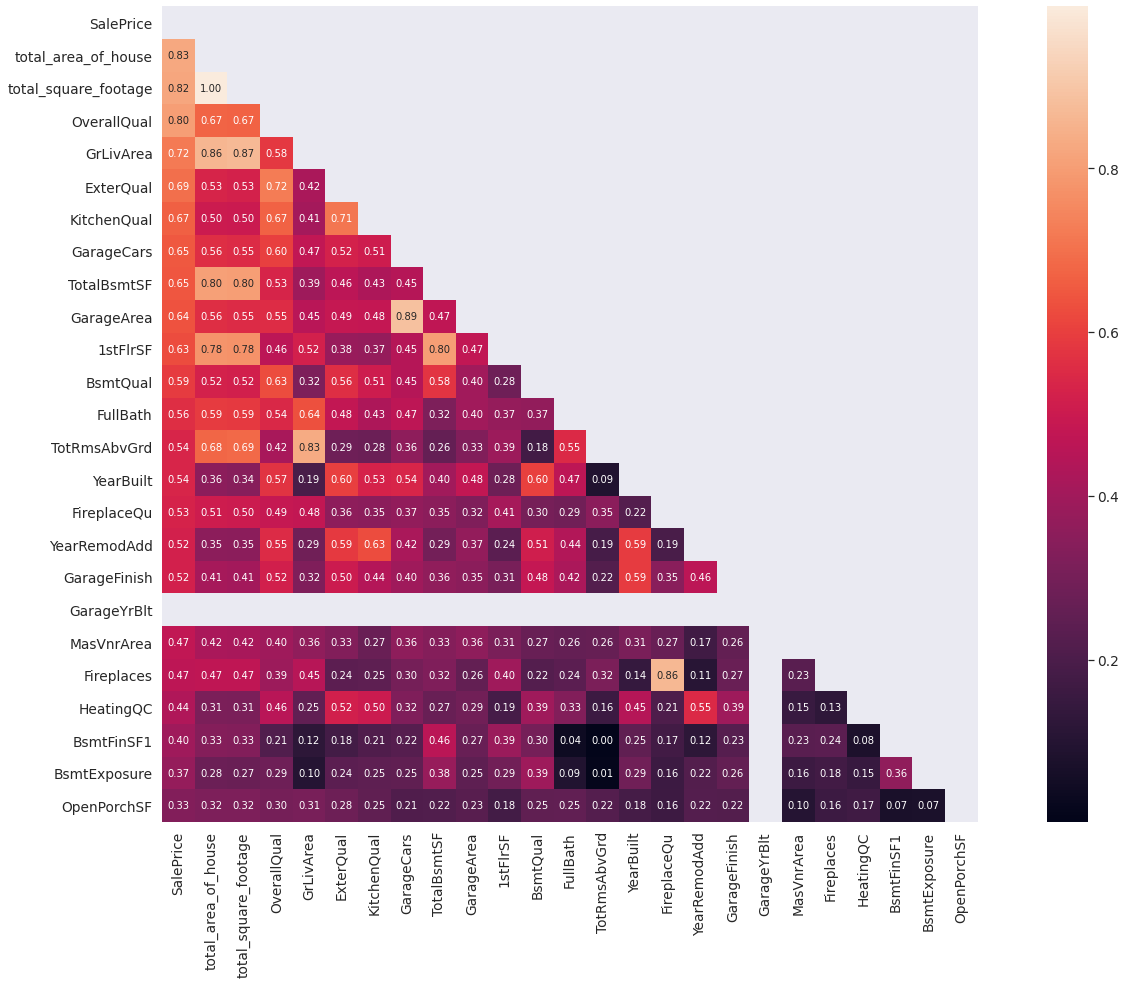

In [23]:
corr_cols = corr_matrix.nlargest(25, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_set[corr_cols].values.T)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig = plt.figure(figsize=(25,15))
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

## Label Encoding

In [24]:
data = train_set.copy()
test_data = test_set.copy()
label_encoder = TolerantLabelEncoder(ignore_unknown=True)
for col in norminal_features:
    label_encoder.fit(data[col].astype(str))
    data[col] = label_encoder.transform(data[col].astype(str))
    test_data[col] = label_encoder.transform(test_data[col].astype(str))


In [25]:
data_x = data.copy().drop(columns=['SalePrice', 'Id'])
data_y = data['SalePrice']

test_data = test_data.drop(columns='Id')


In [26]:
np.any(np.isnan(data_x))

False

## Feature Importance - Mutual Information

In [27]:
def make_mi_scores(train, target):
    mi_scores = mutual_info_regression(train, target)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(data_x, data_y)

In [28]:
mi_scores

total_area_of_house     0.676816
total_square_footage    0.661079
OverallQual             0.559540
Neighborhood            0.513268
GrLivArea               0.478101
                          ...   
MiscFeature             0.000000
LandSlope               0.000000
selling_season          0.000000
Condition2              0.000000
MoSold                  0.000000
Name: MI Scores, Length: 84, dtype: float64

## Feature Importance - Select from Model

In [29]:
selector = SelectFromModel(estimator=LinearRegression())
selector.fit(data_x, data_y)
feature_importance_df = pd.DataFrame(
    {
        'feature': data_x.columns,
        'importance': abs(selector.estimator_.coef_),
        'selected': selector.get_support()
    }
)

In [30]:
select_from_model = feature_importance_df[feature_importance_df['selected']].sort_values(by='importance', ascending=False)

# MODELLING

In [31]:
correlation_features =  corr_cols.drop('SalePrice')
mutual_info_features =mi_scores[:25].index.values
select_from_model_features = select_from_model['feature'].values

model_result = []
model_type = []

In [32]:
std_scaler = StandardScaler()

for col in data_x.columns:
    std_scaler.fit(data_x[col].values.reshape(-1,1))
    data_x[col] = std_scaler.transform(data_x[col].values.reshape(-1,1))
    test_data[col] = std_scaler.transform(test_data[col].values.reshape(-1,1))


In [33]:
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, train_size=0.80, test_size=0.20, random_state=RANDOM_STATE) 

## LINEAR REGRESSION MODEL

### Linear Regression with full dataset

In [34]:
logreg_full = LinearRegression()
logreg_full.fit(train_x, train_y)
logreg_full_pred = logreg_full.predict(validate_x)

In [35]:
logreg_full_rmse = evaluation_metric(logreg_full_pred, validate_y)
model_type.append('LogReg Full')
model_result.append(logreg_full_rmse)

### Linear Regression with correlation columns

In [36]:
train_corr = train_x[correlation_features]
validate_corr = validate_x[correlation_features]
logreg_corr = LinearRegression()
logreg_corr.fit(train_corr, train_y)
logreg_corr_pred = logreg_corr.predict(validate_corr)

In [37]:
logreg_corr_rmse = evaluation_metric(logreg_corr_pred, validate_y)
model_type.append('LogReg Correlation')
model_result.append(logreg_corr_rmse)

### Linear Regression with MI

In [38]:
train_mi = train_x[mutual_info_features]
validate_mi = validate_x[mutual_info_features]
logreg_mi = LinearRegression()
logreg_mi.fit(train_mi,train_y)
logreg_mi_pred = logreg_mi.predict(validate_mi)

In [39]:
logreg_mi_rmse = evaluation_metric(logreg_mi_pred, validate_y)
model_type.append('LogReg Mutual Information')
model_result.append(logreg_mi_rmse)

### Linear Regression with Select From

In [41]:
train_sf = train_x[select_from_model_features]
validate_sf = validate_x[select_from_model_features]
logreg_sf = LinearRegression()
logreg_sf.fit(train_sf,train_y)
logreg_sf_pred = logreg_sf.predict(validate_sf)

In [42]:
logreg_sf_rmse = evaluation_metric(logreg_sf_pred, validate_y)
model_type.append('LogReg SelectFromModel')
model_result.append(logreg_sf_rmse)

## RANDOM FOREST MODEL

## ENSEMBLE

## MODEL EVALUATION

In [43]:
result = pd.DataFrame(
    {
        'feature': model_type,
        'value': model_result
    }
)
result

,feature,value
0,LogReg Full,0.140568
1,LogReg Correlation,0.270572
2,LogReg Mutual Information,0.325638
3,LogReg SelectFromModel,0.175927


# CONCLUSION